### Climate change velocity

Step 1: define some metrics to characterize the distribution like the zero growth isoline or peak krill growth potential isoline.

Step 2: Take the latitudinal position of the metric and plot it as a time series

Step 3: Compute the velocity: the distance between where it ends up and where it started and then divide by the amount of time and you have a velocity



#### Krill Distribution Metrics

In [1]:
from itertools import product

import numpy as np
import xarray as xr

import pop_tools
import xpersist as xp

import util

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colorbar import Colorbar 
from matplotlib import ticker, cm
from matplotlib.ticker import FormatStrFormatter

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean as cmo

plt.style.use('ggplot')

Cannot write to data cache folder '/glade/p/cesmdata/cseg'. Will not be able to download remote data files. Use environment variable 'CESMDATAROOT' to specify another directory.


## Grid Things!

In [2]:
grid = pop_tools.get_grid('POP_gx1v6')
#grid
jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
lat_slice = slice(jnx[0], jnx[-1]+1)
grid = grid.isel(nlat=lat_slice)
#grid

#### Regions:
1. Atlantic /Basin: 50°W to 30°E
2. SW Atlantic sector: 30°W to 70°W
* eastern (30–50 W)
* western (50–70 W) 
* SW Atlantic-Peninsula (10 to 80°W)
5. Indian: 30E - 160E
6. Paciﬁc: 160E - 30W


In [3]:
# define a list of tuples describing our regions: (region_name, logical_array)
so_logic = (grid.TLAT <= -45)
mask_logic = [
    ('Southern Ocean', so_logic), 
    ('Atlantic Basin', so_logic & ((grid.TLONG > 310) | (grid.TLONG < 30))), # 50W to 30E
    ('SW Atlantic', so_logic & ((grid.TLONG > 290) | (grid.TLONG < 30))),  # 70W - 30E
    
    ('SW Eastern', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 310))), #30W (310) - 50W (330) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW Western', so_logic & ((grid.TLONG < 330) & (grid.TLONG > 290))), #50W (330) - 70W (290) # # 30 - 70 70+180 = 250 // 30+180 = 210
    ('SW AP', so_logic & ((grid.TLONG < 350) & (grid.TLONG > 280))),   # 10W (350) to 80°W (280)  
]
# create a region coordinate with the region names
region = xr.DataArray(
    [t[0] for t in mask_logic], 
    dims=('region'), 
)
nregion = len(region)

# create a masked array array
masked_area = xr.DataArray(
    np.zeros((nregion,)+grid.TLAT.shape), 
    dims=('region',)+grid.TLAT.dims,
    coords={'region': region},
    name='masked_area',
)
for i, name_logic in enumerate(mask_logic):
    masked_area.data[i, :, :] = grid.TAREA.where(name_logic[1]).fillna(0.).where(grid.KMT>0)

# subset to the lat range from above
masked_area = masked_area.isel(nlat=lat_slice)
#masked_area  

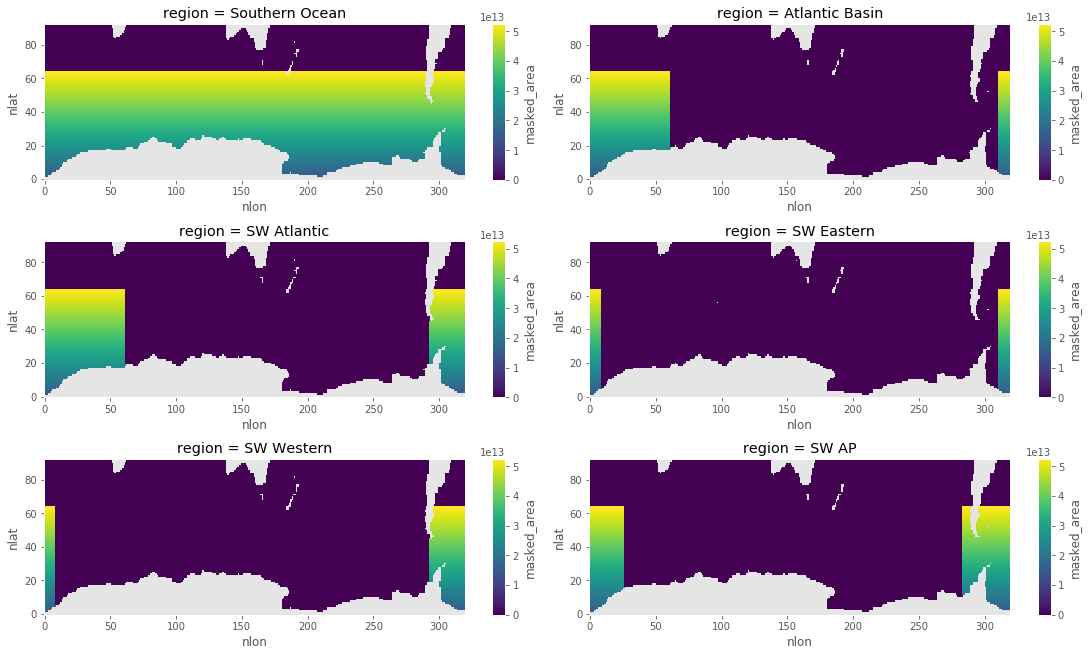

In [4]:
# Check and see if it worked:
ncol = int(np.sqrt(nregion))
nrow = int(nregion/ncol) + min(1, nregion%ncol)

fig, ax = plt.subplots(nrow, ncol, figsize=(15, 3*nrow),
                       constrained_layout=True)

for i, region in enumerate(masked_area.region.values):
    plt.axes(ax.ravel()[i])
    masked_area.sel(region=region).plot()
    plt.savefig('figures/regions-recalc-plot-t.png', transparent = True)

## Load in Data

In [5]:
ds_djf = xr.open_zarr(f'{util.project_tmpdir}/cesm-le-fields-djf.zarr')
ds_djf = ds_djf[['SST', 'Chl_surf', 'KGP']].sel(length = 40).where(ds_djf.TLAT <= -45)
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

## Explore Data

In [6]:
%%time
ds_ctrl_mean = (
        ds_djf.sel(time=slice(1920, 1950))
        .mean(dim=['time', 'member_id']).compute()
)
ds_future_mean = (
        ds_djf.sel(time=slice(2070, 2100))
        .mean(dim=['time', 'member_id']).compute()
)    
#  Check your results if you want:
#ds_future_mean
# cmap = cmo.cm.curl_r
# fig, axes = plt.subplots(2,1, figsize=(8, 4))
# axes
# ds_ctrl_mean['KGP'].plot(ax=axes[0], cmap = cmap)
# ds_future_mean['KGP'].plot(ax=axes[1], cmap = cmap)
# fig.patch.set_facecolor('black')
# plt.tight_layout();

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


CPU times: user 12.9 s, sys: 14.6 s, total: 27.5 s
Wall time: 21.4 s


###### Change in zero growth line between control period and future period

Text(0.5, 1.0, '0 mm day-1 krill GP Ensemble Mean \n 1920-1950 vs 2070-2100')

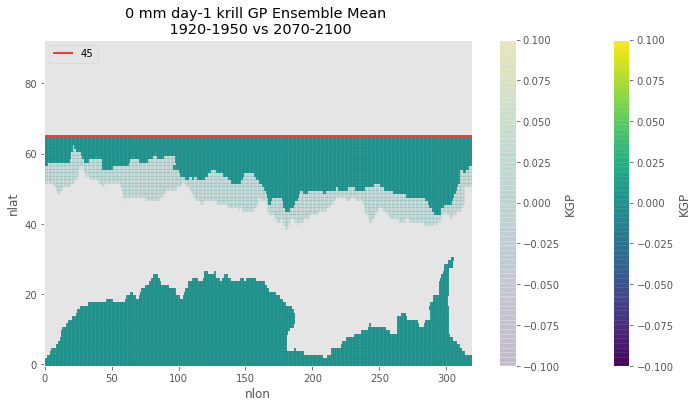

In [25]:
# subset where GP = zero 
ctrl_zero_GP = ds_ctrl_mean.where(ds_ctrl_mean['KGP']==0)
ftr_zero_GP = ds_future_mean.where(ds_future_mean['KGP']==0)

## Plot it!
plt.figure(figsize=(12, 6))
ctrl_zero_GP['KGP'].plot(alpha = 0.9)
ftr_zero_GP['KGP'].plot(alpha = 0.1)
# plt.vlines(290, 0, 65, colors='blue', label = '290')
# plt.vlines(15, 0, 65, colors='yellow', label = '15')
# plt.vlines(305, 0, 65, colors='black', label = '305')
plt.hlines(65, 0, 320, colors='red', label = '45')
# plt.hlines(30, 0, 320, colors='green', label = '30')
plt.legend(loc = 'upper left', ncol=5)
plt.title('0 mm day-1 krill GP Ensemble Mean \n 1920-1950 vs 2070-2100')

## Polar Plotting

In [8]:
# Polar Plottable
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'mean_kgp': ds_djf.KGP.mean('member_id').compute(),
        'mean_sst': ds_djf.SST.mean('member_id').compute(),
        'mean_chl': ds_djf.Chl_surf.mean('member_id').compute(),

        'TLAT': ds_djf.TLAT.compute(),
        'TLONG': ds_djf.TLONG.compute() } ))
dsp

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:   (nlat: 93, nlon: 321, time: 180)
Coordinates:
    length    float64 40.0
  * time      (time) int64 1921 1922 1923 1924 1925 ... 2096 2097 2098 2099 2100
Dimensions without coordinates: nlat, nlon
Data variables:
    TLAT      (nlat, nlon) float64 -79.22 -79.22 -79.22 ... -30.08 -30.08 -30.08
    TLONG     (nlat, nlon) float64 -220.6 -219.4 -218.3 ... 137.2 138.3 139.4
    mean_kgp  (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    mean_sst  (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    mean_chl  (time, nlat, nlon) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan

### Calculate zero growth metric

In [9]:
kgp_lon = dsp.mean_kgp.mean('nlon').compute()
sst_lon = dsp.mean_sst.mean('nlon').compute()
chl_lon = dsp.mean_chl.mean('nlon').compute()
# plt.subplots(figsize=(12, 4))
# kgp_lon.T.plot(alpha = 0.5)
# chl_lon.T.plot(alpha = 0.2)
# plt.tight_layout()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


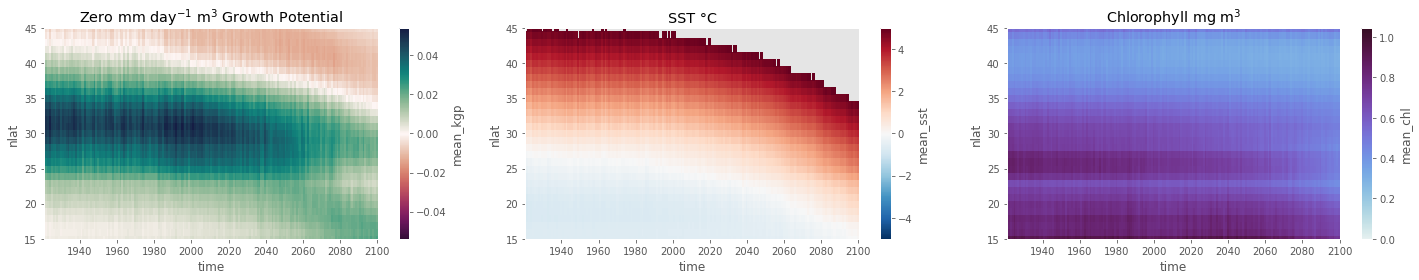

In [15]:
cmap = cmo.cm.curl_r
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
plt.ylim(top=45)

kgp_lon.T.plot(ax=ax1, cmap=cmap)
ax1.set_ylim(top=45, bottom = 15)
ax1.set_title('Zero mm day$^{-1}$ m$^3$ Growth Potential')

sst_lon.where(sst_lon<=5).T.plot(ax=ax2)
ax2.set_ylim(top=45, bottom = 15)
ax2.set_title('SST °C')

chl_lon.T.plot(ax=ax3, cmap=cmo.cm.dense)
ax3.set_ylim(top=45, bottom = 15)
ax3.set_title('Chlorophyll mg m$^3$')

plt.tight_layout()
#plt.savefig('figures/SO-Zero-TS.png', transparent = True)

In [20]:
region = 'SW Atlantic'

zero = ds_djf.where(ds_djf['KGP']==0).where(masked_area.sel(region=region))
zero

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    length     float64 40.0
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
    region     <U14 'SW Atlantic'
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [21]:
kgp_lon = zero.KGP.mean('member_id').mean('nlon').compute()
sst_lon = zero.SST.mean('member_id').mean('nlon').compute()
chl_lon = zero.Chl_surf.mean('member_id').mean('nlon').compute()

/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/glade/work/zephyrs/miniconda3/envs/krill/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [24]:
kgp_lon.contourf(kgp_lon.time, kgp_lon.nlat, kgp_lon)


AttributeError: 'DataArray' object has no attribute 'contourf'

TypeError: Length of x must be number of columns in z.

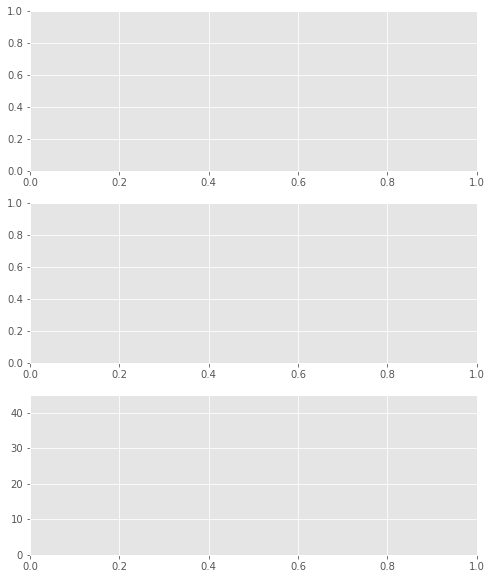

In [23]:
cmap = cmo.cm.curl_r
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 10))
plt.ylim(top=45)

ax1.contourf(kgp_lon.time, kgp_lon.nlat, kgp_lon)

ax1.set_ylim(top=45, bottom = 15)
ax1.set_title('Zero mm day$^{-1}$ m$^3$ Growth Potential')

sst_lon.where(sst_lon<=5).T.plot(ax=ax2)
ax2.set_ylim(top=45, bottom = 15)
ax2.set_title('SST °C')

chl_lon.T.plot(ax=ax3, cmap=cmo.cm.dense)
ax3.set_ylim(top=45, bottom = 15)
ax3.set_title('Chlorophyll mg m$^3$')

plt.tight_layout()
plt.savefig('figures/SW-At-Zero-TS.png', transparent = True)

### Messing around with nlat at zero

In [13]:
zero = ds_djf.where(ds_djf['KGP']==0)  # to celsius
zero

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    length     float64 40.0
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [15]:
zero_n = ds_djf.nlat.where(ds_djf['KGP']==0)  # to celsius
zero_n

<xarray.DataArray 'nlat' (nlat: 93, time: 180, member_id: 34, nlon: 320)>
dask.array<where, shape=(93, 180, 34, 320), dtype=float64, chunksize=(93, 180, 1, 320), chunktype=numpy.ndarray>
Coordinates:
    length     float64 40.0
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon

(array([18114124., 14141489.,  5267172.,   314536.,  4295554., 14853431.,
        17552457., 17625600., 17625600., 19584000.]),
 array([ 0. ,  9.2, 18.4, 27.6, 36.8, 46. , 55.2, 64.4, 73.6, 82.8, 92. ]),
 <a list of 10 Patch objects>)

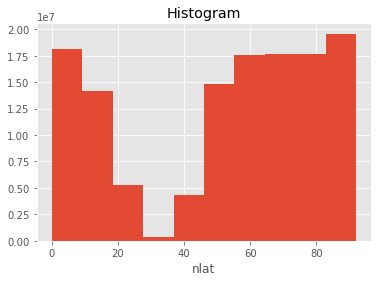

In [16]:
zero_n.plot()

In [17]:
ds_djf

<xarray.Dataset>
Dimensions:    (member_id: 34, nlat: 93, nlon: 320, time: 180)
Coordinates:
    KMT        (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
  * member_id  (member_id) int64 1 2 9 10 11 12 13 ... 34 35 101 102 103 104 105
  * time       (time) int64 1921 1922 1923 1924 1925 ... 2097 2098 2099 2100
    length     float64 40.0
    TAREA      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT       (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG      (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Data variables:
    SST        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    Chl_surf   (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>
    KGP        (time, member_id, nlat, nlon) float64 dask.array<chunksize=(180, 1, 93, 320), meta=np.ndarray>

In [17]:
# Control, Future, STDEV 
#levels = np.linspace(-0.05, 0.22, 21)
#labels = [-0.04, 0, 0.04, 0.9, 0.13, 0.17,0.21] #-0.04, 0.0, 0.04, 0.09, 0.13, 0.17, 0.21

cmap = cmo.cm.curl_r
cmap = cmo.tools.crop_by_percent(cmap, 10, which='min', N=None)

extent = ([-180, 180, -90, -50], ccrs.PlateCarree())
prj = ccrs.SouthPolarStereo()
fmt = '%.2f'

def polar_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     #levels=levels_chng,
                     norm=MidpointNormalize(midpoint=0.),
                     cmap=cmap_chng,
                     transform=ccrs.PlateCarree())
    # contour lines: dc.where(dc>0)
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k', 
                    #levels=level_p,
                    linewidths=.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
   
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    ax.gridlines(linewidth=.25, color='black', alpha=0.7, linestyle='--').n_steps = 90  ## this makes them rounder
    return cf

In [ ]:
################### FIGURE SET-UP ##########################
fig = plt.figure(figsize=(30, 12))
gs = gridspec.GridSpec(2,5, height_ratios=[2,0.1])
#t1, t2, t3, t4, t5 = '1920-1950', '1990-2020', 'Standard Deviation', '$\Delta$ by 2100', 'Time of Emergence'
################### LEFT MOST PLOT ############################
ax = fig.add_subplot(gs[0, 0], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp1],lines = False)
#ax.set_title(f'{t1}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER PLOT ############################
ax = fig.add_subplot(gs[0, 1], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp2],lines = False)
#ax.set_title(f'{t2}', fontsize = 18, fontweight = 'bold',pad=10)
################### CENTER RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 2], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = epoch_plot(dsp[vp3], lines=False)
#ax.set_title(f'{t3}', fontsize = 18, fontweight = 'bold',pad=10)
# ################### COLORBAR FOR LEFT 3 PLOTS ############################
cbax = plt.subplot(gs[1,:3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### 2nd RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 3], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = change_plot(dsp[vp4], dsp[vc], lines=False)
#ax.set_title(f'{t4}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,3]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=16)

################### FAR RIGHT PLOT ############################
ax = fig.add_subplot(gs[0, 4], projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = toe_plot(dsp[vp5])
#ax.set_title(f'{t5}', fontsize = 18, fontweight = 'bold',pad=10)

cbax = plt.subplot(gs[1,4]) # Place it where it should be.
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal')#, ticklocation = 'top')
cb.set_label(f'{unit2}',  labelpad=5, fontsize = 16)
cb.ax.xaxis.set_label_position('bottom')
#cb.ax.set_xticklabels(labels)
cb.ax.tick_params(labelsize=10)

ax = fig.get_axes()
gs.update(hspace=0.1, wspace= 0.16, bottom=0.4)
# --------------------------------------------------------